# Predicting Acceptance of US Visa Applications Using Machine Learning
Capstone Project for SlideRule Intensive Data Science workshop.

Charles Franzen

## The Project

Each year hundreds of thousands of applications are filed for work visas in the US. So many, in fact, that legistated caps on the number of H-1B applications have been reached every single year since 2007. In 2008, the quota was reached on the first day of open applications. In light of this, companies and potential employees that are lucky enough to get their application in via the lottery want to ensure that they have as high a chance as possible of having their application approved.

My project is to investigate application data sets and create models that will predict the acceptance or rejection of a given application. This model could evaluate the strength of an application before it is submitted, and provide insights into how a weak application could be improved. The model will also elucidate the most important factors determining the fate of a visa application.

## The Data

I will be investigating data published by the US Dapartment of Labor. The data sets are comprised of quarterly application data and decisions for different types of visas. I will be focusing on two of these data sets: one that includes a mix of all visa types, and one that is comprised solely of H-1B visas.

The data fields cover a wide range of information, including details about the country of origin of the applicant, location and type of the job, pay and educational requirements of the job, education of the applicant, and whether all regulatory hurdles have been cleared.

H-1B visas are work visas that are only for 'specialty applications', and therefore can act as a bellweather for how much highly-educated talent the US is importing.

## Methodology

I will be treating this as a classification problem. The binary variable 'denied' will indicate whether an application was rejected.

So far I have used logistic regression and decision tree classification to model the all-visa dataset. Next steps include refining the models, investigating similar models for the H-1B subset, and continuing with other machine learning techniques, including SVM.

### Logistic Regression

In order to implement logistic regression, I've had to format the data sets, converting string cell values into integers or floats, and creating dummy variables for categorical data.

Scikit Learn does not provide a method for adjusting the threshold probability for classification, so this had to be adjusted manually.

Using backdata from the Department of Labor, I will test my models and further refine them.

### Decision Tree Classification

Once the data is formatted for Logistic Regression, it is easy to fit it to a decision tree. Decision Trees are somewhat computationaly expensive, so the number of parameter combinations that can be tested is limited.

The threshold 

## Limitations

Since the base rate of application rejection is so low (6.7% for all visa types), it may be difficult to suss out relevant variables. Thus far my models have tended to have a high number of false-negatives (type II errors).

The models may also end up provinding unhelpful insights. For example, the model may identify country of citizenship as a crucial determiner. It won't be helpful to most applicants to tell them to change their citizenship.

## Import Modules

In [1]:
% matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split,  cross_val_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

//anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# setting matplotlib style
plt.style.use('fivethirtyeight')

# All Visas

## Data Loading and Initial Processing
Withdrawn applications are removed from the data set, since there was no decision made.

In [3]:
# loading data
data = pd.read_excel('Data/PERM_Disclosure_Data_FY15_Q4.xlsx', 'DDFY2015_Final')

# removing withdrawn applications
data = data[data['CASE_STATUS'] != 'Withdrawn']

# adding a binary series with 1 indicating that an application was denied
data['denied'] = (data.CASE_STATUS == 'Denied').astype(int)

## Descriptive Statistics

To do:

1. make pie charts for country of origin, education, case status, visa type
2. make histograms for salary/wage, training, and experience requirements

In [4]:
status = data['CASE_STATUS'].value_counts()
status

Certified            40176
Certified-Expired    38762
Denied                5696
Name: CASE_STATUS, dtype: int64

In [5]:
pcert, pcertex, pdenied = (data['CASE_STATUS'].value_counts().values) / float(len(data))
size = len(data)
print 'Certified: \t\t', pcert, '\nCertified-Expired: \t', pcertex, '\nDenied: \t\t', pdenied, '\nSize: \t\t\t', size
                                                                 

Certified: 		0.474702838103 
Certified-Expired: 	0.457995604603 
Denied: 		0.0673015572938 
Size: 			84634


<IPython.core.display.Javascript object>


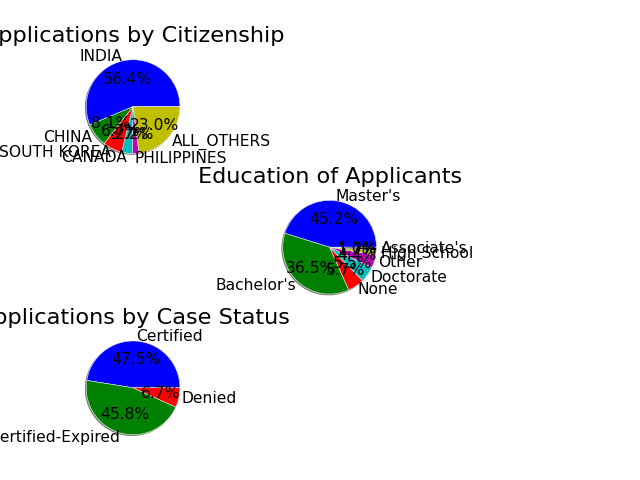

([<matplotlib.patches.Wedge at 0x108eccad0>,
  <matplotlib.text.Text at 0x108fd2e90>])

In [6]:
labels = list(status.index)
fracs = pcert, pcertex, pdenied
the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 0], aspect=1, title='Applications by Case Status')
plt.pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True)

Base rate of denials is low, at 6.7%, and many accepted applications are allowed to expire.

In [7]:
serror = (pdenied*(1-pdenied)/float(len(data))) ** .5
print 'Standard Error: ',serror

Standard Error:  0.000861213341343


### Categorical Data

In [8]:
# possibly interesting columns of categorical data
dfcat = data[['denied', 'EMPLOYER_NAME', 'EMPLOYER_STATE', 'AGENT_FIRM_NAME', 'PW_SOC_TITLE', 'JOB_INFO_EDUCATION', 
              'COUNTRY_OF_CITIZENSHIP', 'CLASS_OF_ADMISSION', 'FOREIGN_WORKER_INFO_EDUCATION', 
              'FOREIGN_WORKER_INFO_MAJOR']]

After exploring the columns, Visa Type, Country of Citizenship, and Education seem to be the most interesting columns.

In [9]:
# visa types with a high rate of denial
dftype = dfcat[['CLASS_OF_ADMISSION', 'denied']]
dftype1 = dftype.groupby('CLASS_OF_ADMISSION').mean()
dftype1['size'] = dftype.groupby('CLASS_OF_ADMISSION').agg(sum)
dftype = dftype1[(dftype1['denied'] > (pdenied + 2*serror)) & (dftype1['size'] >= 10)]
dftype.head()

,denied,size
CLASS_OF_ADMISSION,,
B-1,0.347826,40
B-2,0.265248,187
E-1,0.149123,17
E-2,0.123584,120
E-3,0.071429,11


In [10]:
visa_types = dfcat.groupby('CLASS_OF_ADMISSION').count()['denied']
visa_types = visa_types.sort_values()[:-5:-1]
visa_types

CLASS_OF_ADMISSION
H-1B          64729
L-1            5136
F-1            3163
Not in USA     1554
Name: denied, dtype: int64

In [11]:
# countries with a high rate of denial
dfcit = dfcat[['COUNTRY_OF_CITIZENSHIP', 'denied']]
dfcit1 = dfcit.groupby('COUNTRY_OF_CITIZENSHIP').mean()
dfcit1['size'] = dfcit.groupby('COUNTRY_OF_CITIZENSHIP').agg(sum)
dfcit = dfcit1[(dfcit1['denied'] > (pdenied + 2*serror)) & (dfcit1['size'] >= 10)]
dfcit.sort_values('denied')[::-1].head()

,denied,size
COUNTRY_OF_CITIZENSHIP,,
GAMBIA,0.850000,17
SLOVAKIA,0.400000,12
GUATEMALA,0.303371,27
ECUADOR,0.270408,53
EL SALVADOR,0.237624,24


In [12]:
countries = dfcat.groupby('COUNTRY_OF_CITIZENSHIP').count()['denied']
countries = countries.sort_values()[::-1][:5]
countries['ALL_OTHERS'] = 19427
countries

COUNTRY_OF_CITIZENSHIP
INDIA          47705
CHINA           6843
SOUTH KOREA     5645
CANADA          3139
PHILIPPINES     1875
ALL_OTHERS     19427
Name: denied, dtype: int64

In [13]:
country_labels = list(countries.index)
country_fracs = countries.values
plt.subplot(the_grid[1, 0], aspect=1, title='Applications by Citizenship')
plt.pie(country_fracs, labels=country_labels, autopct='%1.1f%%', shadow=True)

([<matplotlib.patches.Wedge at 0x109118c10>,
  <matplotlib.text.Text at 0x109c289d0>])

In [14]:
dfcat.groupby(['FOREIGN_WORKER_INFO_EDUCATION'])['denied'].mean().sort_values()

FOREIGN_WORKER_INFO_EDUCATION
Doctorate      0.033010
Master's       0.051275
Bachelor's     0.053348
Other          0.074332
Associate's    0.185270
None           0.228803
High School    0.270021
Name: denied, dtype: float64

In [15]:
education = dfcat.groupby('FOREIGN_WORKER_INFO_EDUCATION').count()['denied'].sort_values()[::-1]
education

FOREIGN_WORKER_INFO_EDUCATION
Master's       38245
Bachelor's     30910
None            4812
Doctorate       4635
Other           3740
High School     1411
Associate's      869
Name: denied, dtype: int64

In [16]:
status_labels = list(status.index)
status_fracs = pcert, pcertex, pdenied
the_grid = GridSpec(3, 3)
plt.subplot(the_grid[2, 0], aspect=1, title='Applications by Case Status')
plt.pie(status_fracs, labels=status_labels, autopct='%1.1f%%', shadow=True)

country_labels = list(countries.index)
country_fracs = countries.values
plt.subplot(the_grid[0, 0], aspect=1, title='Applications by Citizenship')
plt.pie(country_fracs, labels=country_labels, autopct='%1.1f%%', shadow=True)

ed_labels = list(education.index)
ed_fracs = education.values
plt.subplot(the_grid[1, 1], aspect=1, title='Education of Applicants')
plt.pie(ed_fracs, labels=ed_labels, autopct='%1.1f%%', shadow=True)

([<matplotlib.patches.Wedge at 0x10b7f6890>,
  <matplotlib.text.Text at 0x10ba942d0>])

In [17]:
dfcat.groupby(['JOB_INFO_EDUCATION'])['denied'].mean().sort_values()

JOB_INFO_EDUCATION
Doctorate      0.025573
Master's       0.047168
Bachelor's     0.051324
Other          0.075218
Associate's    0.188406
None           0.233772
High School    0.304193
Name: denied, dtype: float64

Applicants with at least a Bachelor's have significantly lower rates of rejection than those without one.

## Data Preparation for Logistic Regression

All of the data are given as unicode, even the numbers, so it has to be converted into the proper data type before the regression can be run. Additionally, dummy variables need to be created for the categorical data.

In [18]:
# interesting fields with binary or numerical data
data_fields = ['REFILE', 'EMPLOYER_NUM_EMPLOYEES', 
               'FOREIGN_WORKER_OWNERSHIP_INTEREST', 'PW_AMOUNT_9089', 'WAGE_OFFER_FROM_9089', 'WAGE_OFFER_TO_9089', 
               'JOB_INFO_TRAINING', 'JOB_INFO_TRAINING_NUM_MONTHS', 'JOB_INFO_EXPERIENCE', 
               'JOB_INFO_EXPERIENCE_NUM_MONTHS', 'JOB_INFO_ALT_FIELD', 'JOB_INFO_ALT_COMBO_ED_EXP', 
               'JOB_INFO_ALT_CMB_ED_OTH_YRS', 'JOB_INFO_FOREIGN_ED', 'JOB_INFO_ALT_OCC', 'JOB_INFO_ALT_OCC_NUM_MONTHS', 
               'JOB_INFO_JOB_REQ_NORMAL', 'JOB_INFO_FOREIGN_LANG_REQ', 'JOB_INFO_COMBO_OCCUPATION',
               'JI_FOREIGN_WORKER_LIVE_ON_PREMISES', 'JI_LIVE_IN_DOMESTIC_SERVICE', 'JI_LIVE_IN_DOM_SVC_CONTRACT', 
               'RECR_INFO_PROFESSIONAL_OCC', 'RECR_INFO_COLL_UNIV_TEACHER', 'RECR_INFO_COLL_TEACH_COMP_PROC', 
               'RI_POSTED_NOTICE_AT_WORKSITE', 'RI_LAYOFF_IN_PAST_SIX_MONTHS', 'RI_US_WORKERS_CONSIDERED', 
               'FOREIGN_WORKER_INFO_TRAINING_COMP', 'FOREIGN_WORKER_INFO_REQ_EXPERIENCE', 
               'FOREIGN_WORKER_INFO_ALT_EDU_EXPERIENCE', 'FOREIGN_WORKER_INFO_REL_OCCUP_EXP', 
               'PREPARER_INFO_EMP_COMPLETED']
dflogit = data[data_fields]

In [19]:
dflogit.head()

,REFILE,EMPLOYER_NUM_EMPLOYEES,FOREIGN_WORKER_OWNERSHIP_INTEREST,PW_AMOUNT_9089,WAGE_OFFER_FROM_9089,WAGE_OFFER_TO_9089,JOB_INFO_TRAINING,JOB_INFO_TRAINING_NUM_MONTHS,JOB_INFO_EXPERIENCE,JOB_INFO_EXPERIENCE_NUM_MONTHS,...,RECR_INFO_COLL_UNIV_TEACHER,RECR_INFO_COLL_TEACH_COMP_PROC,RI_POSTED_NOTICE_AT_WORKSITE,RI_LAYOFF_IN_PAST_SIX_MONTHS,RI_US_WORKERS_CONSIDERED,FOREIGN_WORKER_INFO_TRAINING_COMP,FOREIGN_WORKER_INFO_REQ_EXPERIENCE,FOREIGN_WORKER_INFO_ALT_EDU_EXPERIENCE,FOREIGN_WORKER_INFO_REL_OCCUP_EXP,PREPARER_INFO_EMP_COMPLETED
0,N,1935,N,"83,366.00","90,000.00","95,000.00",N,NaN,N,NaN,...,N,NaN,Y,N,NaN,A,A,A,Y,N
1,N,350,N,"16,973.00","16,973.00",NaN,N,NaN,N,NaN,...,N,NaN,Y,N,NaN,A,A,A,A,N
2,N,4,N,"49,982.00","65,000.00",NaN,N,NaN,Y,36,...,N,NaN,Y,N,NaN,A,Y,A,A,N
3,N,8,N,"43,514.00","43,514.00",NaN,N,NaN,N,NaN,...,N,NaN,Y,N,NaN,A,A,A,A,N
4,N,350,N,"16,973.00","16,973.00",NaN,N,NaN,N,NaN,...,N,NaN,Y,N,NaN,A,A,A,A,N


The data cleaning ended up being a little tricky, as some columns were initially dropped without me noticing. The cleaning operation converts unicode numbers into floats and Y/N indicators into binary.

In [20]:
def remove_commas(uni):
    # converts unicode numbers with commas into floats
    string = str(uni)
    if ',' in string:
        return float(string.replace(',', ''))
    elif '#' in string:
        return 0

def data_clean(df):
    # formats datatypes to binary for indicators or floats for numbers
    columns = df.columns
    dfr = pd.DataFrame()
    for column in columns:
        name = str(column)
        name = name.lower()
        if str(df[column][1]) in ['Y', 'N']:
            dfr[name] = (df[column] == 'Y').astype(int)
        else:
            try:
                dfr[name] = df[column].apply(str).apply(remove_commas)
            except ValueError:
                continue
    return dfr

def add_columns(df1, df2, columns):
    # adds columns from one dataframe to another
    for column in columns:
        df2[column] = df1[column]

In [21]:
dflogit = data_clean(dflogit)

In [22]:
# adding prevailing wage comparison features
dflogit['lowball'] = (dflogit['pw_amount_9089'] > dflogit['wage_offer_from_9089']).apply(int)
dflogit['highoffer'] = (dflogit['pw_amount_9089'] < dflogit['wage_offer_to_9089']).apply(int)

I thought that perhaps the how the wage offered to the immigrant worker compared to the prevailing wage of the profession might affect rejection, so I added two feature to identify lowball and higher-than-normal offers.

In [23]:
# formatting data for logistic regression

new_columns = ['JOB_INFO_EDUCATION', 'COUNTRY_OF_CITIZENSHIP', 'CLASS_OF_ADMISSION', 'FOREIGN_WORKER_INFO_EDUCATION',
               'denied']
add_columns(data, dflogit, new_columns)

Missing data is replaced with a 0, since classifiers cannot handle NaNs. setting the default to 0 will minimize the distortion.

In [24]:
# dealing with missing data
dflogit = dflogit.fillna(0)

In [25]:
dflogit.head()

,refile,employer_num_employees,foreign_worker_ownership_interest,pw_amount_9089,wage_offer_from_9089,wage_offer_to_9089,job_info_training,job_info_training_num_months,job_info_experience,job_info_experience_num_months,...,foreign_worker_info_alt_edu_experience,foreign_worker_info_rel_occup_exp,preparer_info_emp_completed,lowball,highoffer,JOB_INFO_EDUCATION,COUNTRY_OF_CITIZENSHIP,CLASS_OF_ADMISSION,FOREIGN_WORKER_INFO_EDUCATION,denied
0,0,0,0,83366,90000,95000,0,0,0,0,...,0,0,0,0,1,Bachelor's,INDIA,H-1B,Bachelor's,0
1,0,0,0,16973,16973,0,0,0,0,0,...,0,0,0,0,0,None,SOUTH KOREA,0,None,1
2,0,0,0,49982,65000,0,0,0,1,0,...,0,0,0,0,0,Doctorate,GERMANY,H-1B,Doctorate,1
3,0,0,0,43514,43514,0,0,0,0,0,...,0,0,0,0,0,Master's,SOUTH KOREA,E-2,Master's,0
4,0,0,0,16973,16973,0,0,0,0,0,...,0,0,0,0,0,None,SOUTH KOREA,0,None,1


In [26]:
# checking that no columns or data points were dropped
print 'n: ', len(dflogit)
print 'features: ', len(dflogit.columns)

# checking data types
dflogit.dtypes

n:  84634
features:  40


refile                                      int64
employer_num_employees                      int64
foreign_worker_ownership_interest           int64
pw_amount_9089                            float64
wage_offer_from_9089                      float64
wage_offer_to_9089                        float64
job_info_training                           int64
job_info_training_num_months                int64
job_info_experience                         int64
job_info_experience_num_months              int64
job_info_alt_field                          int64
job_info_alt_combo_ed_exp                   int64
job_info_alt_cmb_ed_oth_yrs                 int64
job_info_foreign_ed                         int64
job_info_alt_occ                            int64
job_info_alt_occ_num_months                 int64
job_info_job_req_normal                     int64
job_info_foreign_lang_req                   int64
job_info_combo_occupation                   int64
ji_foreign_worker_live_on_premises          int64


In [27]:
wages = dflogit[['pw_amount_9089', 'wage_offer_from_9089', 'wage_offer_to_9089']].replace('0', np.nan)
wages.describe()

,pw_amount_9089,wage_offer_from_9089,wage_offer_to_9089
count,82951.000000,82247.000000,22451.000000
mean,85402.096103,93688.169319,127946.312091
std,38569.882008,39830.833135,44435.788980
min,1067.200000,1060.000000,1000.000000
25%,67808.000000,72467.000000,102200.000000
50%,84802.000000,90459.000000,127300.000000
75%,103938.000000,110410.000000,148400.000000
max,5067600.000000,1145000.000000,1347000.000000


<IPython.core.display.Javascript object>


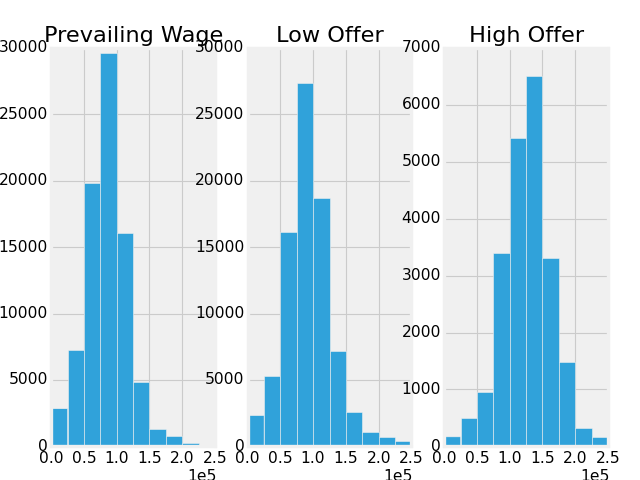

In [28]:
# histograms of wage data
fig, ax = plt.subplots(ncols=3)
index = 0
titles = ['Prevailing Wage', 'Low Offer', 'High Offer']
for column in wages.columns:
    column = str(column)
    ax[index].hist(wages[column].values, range=(0, 250000))
    ax[index].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[index].set_title(titles[index])
    index += 1

In [29]:
# creating a formula for dmatrices, including dummy variables
params = dflogit.columns[:-5]
dummies = ['C(JOB_INFO_EDUCATION)', 'C(COUNTRY_OF_CITIZENSHIP)', 'C(CLASS_OF_ADMISSION)', 'C(FOREIGN_WORKER_INFO_EDUCATION)']
f = 'denied ~ ' + ' + '.join(params) + ' + ' + ' + '.join(dummies)

In [30]:
# convert pandas dataframe into numpy arrays for sklearn logit
y, X = dmatrices(f, dflogit, NA_action='raise', return_type="dataframe")

# checking to see that none of the data points were lost
print 'n: ', len(y)
print 'features: ', len(X.columns)

n:  84634
features:  278


There are about 300x as many data points as features.

In [31]:
# flattening y into a 1-D array
y = np.ravel(y)

# splitting data in to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)

## Logistic Regression

Using grid search and cross validation, a model is fit to the training set.

In [34]:
%%time
logit_params = {'C': [.01, .1, 1., 10., 100.]}
logit = LogisticRegression(class_weight='balanced')
lgt = GridSearchCV(logit, logit_params, cv=10)
lgt.fit(X_train, y_train)

CPU times: user 1min 22s, sys: 6.42 s, total: 1min 29s
Wall time: 1min 32s


The null hypothesis for this model is to simply guess that all applications will be accepted. As will be shown, though, comparing the accuracy of the model and the null hypothesis is not an adequate way of evaluating the model.

In [35]:
# model accuracy
print 'Acc: ', lgt.score(X_test, y_test)

# null hypothesis
null = 1 - y_test.mean()

print 'Null: ', null

Acc:  0.674031190926
Null:  0.935491493384


At first glance, the model is doing worse than the null (accepting every application).

### Evaluating the Model

The default decision point for logistic regression is .5, but this can be adjusted manually to further optimize the model. My goals are to maximize recall and precision for rejected applications.

In [36]:
def decision_threshold(clf, X, cutoff=.5):
    ''' Adjusts the decision cutoff for sklearn classifier predictions
    
    Parameters: 
    clf -- a sklearn classifier object
    X -- a numpy array of unlabeled data
    cutoff --  a float between 0 and 1
    
    Returns:
    a numpy array of binary predictions
    '''
    probs = clf.predict_proba(X)
    count = []
    for prob in probs:
        if prob[1] > cutoff:
            count.append(1)
        else:
            count.append(0)
    return np.array(count)

In [37]:
# adjusting the decision cutoff
pred = decision_threshold(lgt, X_test, .57)

In [98]:
# generating evaluation metrics
def classifier_evaluation(true_labels, predictions): 
    print 'Acc: ', metrics.accuracy_score(true_labels, predictions), '\n'
    print metrics.confusion_matrix(true_labels, predictions)
    print metrics.classification_report(true_labels, predictions)

Adjusting the decision cutoff has already greatly improved the accuracy of the model. In the confusion matrix, rejected applications are labeled 1.

In [101]:
classifier_evaluation(y_test, pred)

Acc:  0.818998109641 

[[6655 1263]
 [ 269  277]]
             precision    recall  f1-score   support

        0.0       0.96      0.84      0.90      7918
        1.0       0.18      0.51      0.27       546

avg / total       0.91      0.82      0.86      8464



While the model does have a lot of false-positives, these are not very costly. The result will simply be flagging an application as a possible rejection, leading to a strengthening of a possible weak application. The model identified over half of all rejections, and flagged about one sixth of accepted applications as weak. This means that the model *is* usefull in that applications classified as weak are rejected at triple the base-rate ad applications classified as less risky are rejected at a lower than normal rate.

In [40]:
# 10-fold cross-validation
logit_scores = cross_val_score(lgt.best_estimator_, X, y, scoring='accuracy', cv=10)
print logit_scores
print logit_scores.mean()

[ 0.61873819  0.67190454  0.69506144  0.67651229  0.76854915  0.75732514
  0.76923077  0.76474064  0.6665091   0.71507918]
0.710365041918


Variability in CV scores shows that sampling for the train-test split may not be totally random, or that the model may be overfitting the training data.

### The Results

In [42]:
# examining the coefficients
logit_coef = pd.DataFrame(zip(X.columns, np.transpose(lgt.best_estimator_.coef_))).sort_values(by=1)
logit_coef.head(30)

,0,1
79,C(COUNTRY_OF_CITIZENSHIP)[T.INDIA],[-0.176251864024]
257,job_info_alt_occ,[-0.160139046492]
254,job_info_alt_combo_ed_exp,[-0.106160750145]
205,C(CLASS_OF_ADMISSION)[T.H-1B],[-0.0929349119944]
251,job_info_experience,[-0.0922471474181]
5,C(JOB_INFO_EDUCATION)[T.Master's],[-0.0788470818622]
215,C(CLASS_OF_ADMISSION)[T.L-1],[-0.074359525691]
265,recr_info_professional_occ,[-0.0624293705427]
253,job_info_alt_field,[-0.0501670068204]
238,C(FOREIGN_WORKER_INFO_EDUCATION)[T.Doctorate],[-0.0438859209559]


In [43]:
logit_coef.tail(30)

,0,1
53,C(COUNTRY_OF_CITIZENSHIP)[T.ECUADOR],[0.0144200535337]
134,C(COUNTRY_OF_CITIZENSHIP)[T.POLAND],[0.0155488944964]
178,C(COUNTRY_OF_CITIZENSHIP)[T.UNITED KINGDOM],[0.0155883396828]
243,refile,[0.0156722409054]
182,C(COUNTRY_OF_CITIZENSHIP)[T.VENEZUELA],[0.0157104588592]
275,preparer_info_emp_completed,[0.0197767888646]
196,C(CLASS_OF_ADMISSION)[T.E-2],[0.0206896202151]
262,ji_foreign_worker_live_on_premises,[0.0224494354317]
245,foreign_worker_ownership_interest,[0.0308933227726]
199,C(CLASS_OF_ADMISSION)[T.F-1],[0.0318479576288]


According to the model, the strongest factor leading to application rejection is whether a job opportunity has normal requirements. This may show that Homeland Security may question the need for a foreign worker when the job requirements are not extraordinary.

Education requirements also matter: positions and applicants without at least a Bachelor's are rejected at high rates. Applicants from Mexico, the Philippines, South Korea are also rejected at relatively high rates. 

Interestingly, foreign workers with an ownership stake in the hiring company may be at a disadvantage. Perhaps this is intended to encourage moneyed immigrants to simply apply for an investor visa (EB-5 and E-2). Some markers for rejection seem to point to a possibility for exploitation, with jobs requiring the worker to live on-site and live-in domestic workers facing heightened scrutiny.

The strongest strengthening features is Indian citizenship. Indians are rejected at the lowest rate of any nationality. Other strengthening factors show that unusual job requirements high worker education improve chances for approval. This may show that jobs requiring a high degree of specialization may be difficult to fill in the US, so companies are justified in hiring foreign talent. Job offers that accept workers with experience with other occupations or fields of study are rarely rejected. Perhaps these are jobs in new fields, with so few experienced professionals that companies must look to workers with only tangential experience.

Education and pay are other important factors: jobs requiring a high level of education are more likely to recieve approval, as well as jobs that offer higher pay than the prevailing wage.

All of this leads towards a narrative where highly specialized positions for which there may be few qualified applicants are the most likely to recieve approval for US work visas.

## Decision Tree

The decision tree can take quite a long time to fit, so I had to limit the size of the parameter grid, and k-fold cross validation to five partitions.

In [52]:
%%time
tree_params = {'min_samples_split': [4, 8, 16], 
               'min_samples_leaf': [2, 4, 8]}
dtc = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), tree_params, cv=5)
dtc.fit(X_train, y_train)

CPU times: user 3min 52s, sys: 6.76 s, total: 3min 59s
Wall time: 4min 4s


In [55]:
dtc.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 4}

In [65]:
print 'Acc: ', dtc.score(X_test, y_test)
print 'Null: ', null

Acc:  0.889768431002
Null:  0.935491493384


The tree is quite a bit more accurate than the logistic regression, but still worse than the null hypothesis.

### Evaluating the Model

In [103]:
# Adjusting decision cutoff to balance type I and type II errors
tpred = decision_threshold(dtc, X_test, .15)
classifier_evaluation(y_test, tpred)

Acc:  0.883979206049 

[[7206  712]
 [ 270  276]]
             precision    recall  f1-score   support

        0.0       0.96      0.91      0.94      7918
        1.0       0.28      0.51      0.36       546

avg / total       0.92      0.88      0.90      8464



The decision tree performs better than logistic regression overall, identifying well over half of the rejected applications, with flagged applications rejected at more than four times the null rate. Running an application through both models will give a better idea of the risk. Applications flagged by logit but not decision tree have a higher chance of being false positives, and may not be especially weak. Applications flagged by the tree but not logit may also be false positives, but should be regarded with more suspicion than those only flagged by logit, due to the lower rate of type 1 errors in the tree model. Applications classified as weak by both models are at an especially high risk of rejection.

In [69]:
# evaluating the model using 10-fold cross-validation
tree_scores = cross_val_score(dtc.best_estimator_, X, y, scoring='accuracy', cv=10)
print tree_scores
print tree_scores.mean()

[ 0.81911626  0.85267013  0.86968336  0.88409735  0.89886578  0.89461248
  0.89637244  0.89708141  0.88666982  0.88785157]
0.878702061633


Consistent cross validation scores indicate that the model is not overfitting the training data.

### Results

In [70]:
# examining the feature importances
pd.DataFrame(zip(X.columns, np.transpose(dtc.best_estimator_.feature_importances_ ))).sort_values(1).tail(30)

,0,1
199,C(CLASS_OF_ADMISSION)[T.F-1],0.003256
133,C(COUNTRY_OF_CITIZENSHIP)[T.PHILIPPINES],0.003392
241,C(FOREIGN_WORKER_INFO_EDUCATION)[T.None],0.003662
238,C(FOREIGN_WORKER_INFO_EDUCATION)[T.Doctorate],0.004184
3,C(JOB_INFO_EDUCATION)[T.Doctorate],0.004319
260,job_info_foreign_lang_req,0.004356
219,C(CLASS_OF_ADMISSION)[T.Not in USA],0.005200
39,C(COUNTRY_OF_CITIZENSHIP)[T.CANADA],0.005293
7,C(JOB_INFO_EDUCATION)[T.Other],0.006605
265,recr_info_professional_occ,0.006728


The Decision Tree identifies some new features as being important to visa success. According to the tree, the wages offered and the prevailing wage for the job are the most important factors: the higher the pay, the better the chances for acceptance. Strengthening factors have far more influence on acceptance than weakening factors, which makes sense, given the low rate or rejection. Another new insight from the tree model is that having the employer complete the application is a significant factor. Other than that, the important features match well with those identified by logistic regression. The decision tree corroborates the earlier picture, with highly paid specialists having the highest acceptance rates.

## Model Comparison

In [71]:
metrics.confusion_matrix(pred, tpred)

array([[6379,  545],
       [1097,  443]])

In [72]:
(tpred == pred).mean()

0.80600189035916825

The models agree in about 81% of cases.

## Random Forest

Random forest is an ensemble method that creates a random forest of decision trees, picking the best one for the classifier.

In [84]:
%%time
forest_params = {'oob_score': [True, False], 
                 'min_samples_split': [8, 16], 
                 'min_samples_leaf': [4, 8]}
rfc = GridSearchCV(RandomForestClassifier(), forest_params, cv=5)
rfc.fit(X_train, y_train)

CPU times: user 2min 3s, sys: 7.22 s, total: 2min 10s
Wall time: 2min 12s


In [108]:
print 'Acc: ', rfc.score(X_test, y_test)
print 'Null: ', null

Acc:  0.942107750473
Null:  0.935491493384


The random forest is only doing slightly better than the null.

In [109]:
# Adjusting decision cutoff to balance type I and type II errors
fpred = decision_threshold(rfc, X_test, .135)

classifier_evaluation(y_test, fpred)

Acc:  0.883624763705 

[[7192  726]
 [ 259  287]]
             precision    recall  f1-score   support

        0.0       0.97      0.91      0.94      7918
        1.0       0.28      0.53      0.37       546

avg / total       0.92      0.88      0.90      8464



## Gradient Boosting

Gradient boosting is an ensemble method that build successive models based on decision trees. It takes a while on my machine, so I can't do much tuning of parameters.

In [112]:
%%time
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

CPU times: user 5min 31s, sys: 13.3 s, total: 5min 44s
Wall time: 5min 51s


In [114]:
clf.score(X_test, y_test)

0.9426984877126654

In [115]:
gb_pred = decision_threshold(clf, X_test, .1)

classifier_evaluation(y_test, gb_pred)

Acc:  0.858577504726 

[[6985  933]
 [ 264  282]]
             precision    recall  f1-score   support

        0.0       0.96      0.88      0.92      7918
        1.0       0.23      0.52      0.32       546

avg / total       0.92      0.86      0.88      8464



## Voting Classifier

In [116]:
predictions = [pred, tpred, fpred, gb_pred]

def classifier_agreement(predictions):
    d = len(predictions)
    result = []
    for pred in predictions:
        for pred2 in predictions:
            result.append(round((pred == pred2).mean(), 3))
    result =  np.array(result)
    result.shape = (d, d)
    return result
    
classifier_agreement(predictions)

array([[ 1.   ,  0.806,  0.902,  0.936],
       [ 0.806,  1.   ,  0.864,  0.841],
       [ 0.902,  0.864,  1.   ,  0.941],
       [ 0.936,  0.841,  0.941,  1.   ]])

In [124]:
predictions[1:]

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0])]

In [128]:
def voting_classifier(predictions):
    return (sum(predictions) >= (len(predictions)/2.)).astype(int)

vpred = voting_classifier(predictions[1:])

classifier_evaluation(y_test, vpred)

Acc:  0.888350661626 

[[7238  680]
 [ 265  281]]
             precision    recall  f1-score   support

        0.0       0.96      0.91      0.94      7918
        1.0       0.29      0.51      0.37       546

avg / total       0.92      0.89      0.90      8464



# H-1B Visas

In [ ]:
hdf = dflogit[dflogit.CLASS_OF_ADMISSION == 'H-1B']

In [687]:
# prep dataframes for sklearn logit
hy, hX = dmatrices(f, hdf, NA_action='raise', return_type="dataframe")
hX.columns

Index([u'Intercept', u'C(JOB_INFO_EDUCATION)[T.Bachelor's]',
       u'C(JOB_INFO_EDUCATION)[T.Doctorate]',
       u'C(JOB_INFO_EDUCATION)[T.High School]',
       u'C(JOB_INFO_EDUCATION)[T.Master's]', u'C(JOB_INFO_EDUCATION)[T.None]',
       u'C(JOB_INFO_EDUCATION)[T.Other]',
       u'C(COUNTRY_OF_CITIZENSHIP)[T.AFGHANISTAN]',
       u'C(COUNTRY_OF_CITIZENSHIP)[T.ALBANIA]',
       u'C(COUNTRY_OF_CITIZENSHIP)[T.ALGERIA]',
       ...
       u'job_info_job_req_normal', u'job_info_foreign_lang_req',
       u'job_info_combo_occupation', u'ji_foreign_worker_live_on_premises',
       u'ji_live_in_domestic_service', u'recr_info_professional_occ',
       u'recr_info_coll_univ_teacher', u'ri_posted_notice_at_worksite',
       u'ri_layoff_in_past_six_months', u'preparer_info_emp_completed'],
      dtype='object', length=209)

In [690]:
# flattening hy into a 1-D array
hy = np.ravel(hy)

In [692]:
# creating a logistic regression model, and fit with hX and hy
hmodel = LogisticRegression()
hmodel = hmodel.fit(hX, hy)

In [695]:
# checking the accuracy on the training set
hmodel.score(hX, hy)

0.95153640562962505

In [696]:
hy.mean()

0.048000123592207511

In [697]:
# examining the coefficients
(pd.DataFrame(zip(hX.columns, np.transpose(hmodel.coef_))).sort_values(by=1))

,0,1
192,job_info_experience_num_months,[-0.00499028835077]
190,job_info_training_num_months,[-0.0031027054786]
195,job_info_alt_cmb_ed_oth_yrs,[-0.00126795991454]
196,job_info_foreign_ed,[-0.000863969311314]
0,Intercept,[-0.000836867036345]
206,ri_posted_notice_at_worksite,[-0.000794645661158]
191,job_info_experience,[-0.000698548603988]
204,recr_info_professional_occ,[-0.000631678812752]
199,job_info_job_req_normal,[-0.000561541567973]
197,job_info_alt_occ,[-0.000421074696638]


In [698]:
# evaluating the model by splitting into train and test sets
hX_train, hX_test, hy_train, hy_test = train_test_split(hX, hy, test_size=.1, random_state=0)
hmodel2 = LogisticRegression()
hmodel2.fit(hX_train, hy_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [699]:
# predicting class labels for the test set
hpredicted = hmodel2.predict(hX_test)
hpredicted

array([ 0.,  0.,  0., ...,  1.,  0.,  0.])

In [709]:
# generating class probabilities, the adjusting the decision cutoff
hprobs = hmodel2.predict_proba(hX_test)
hcount = []
for prob in hprobs:
    if prob[1] > .05:
        hcount.append(1)
    else:
        hcount.append(0)
hpredict2 = np.array(hcount)

In [710]:
# generating evaluation metrics
print metrics.accuracy_score(hy_test, hpredict2)
print metrics.roc_auc_score(hy_test, hprobs[:, 1])

0.575312837942
0.609608244279


In [711]:
print metrics.confusion_matrix(hy_test, hpredict2)
print metrics.classification_report(hy_test, hpredict2)

[[3545 2606]
 [ 143  179]]
             precision    recall  f1-score   support

        0.0       0.96      0.58      0.72      6151
        1.0       0.06      0.56      0.12       322

avg / total       0.92      0.58      0.69      6473

